# **Github Organizations and Collaborations**
## **Zagaria Simone, 2145389**

## **Importing the Libraries**

In [ ]:
# Importing all Libraries

import numpy as np 
import pandas as pd
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from networkx.algorithms import bipartite
from networkx.algorithms.community import louvain_communities, girvan_newman
from networkx.algorithms.community import modularity
from networkx.algorithms.community.quality import performance, coverage
from collections import defaultdict
import csv
import random as r
import powerlaw
r.seed(42)  # Ensure reproducibility


c:\Users\nephr\AppData\Local\Programs\Python\Python311\Lib\site-packages\dash_bootstrap_components\_table.py:5: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  import dash_html_components as html


## **Creation of the Starting Graph from the Dataset**

In this section, we will create a bipartite graph from the scraped data, where nodes represent organizations and members, and edges indicate collaborations between them. Member nodes will also include their country of origin as additional information.

In [24]:
# Load repository names
repo_names = []
with open('ent.github.repository.name', 'r') as file:
    for line in file:
        repo_names.append(line.strip())  # Collect repository names in order

# Parameters from metadata
num_repos = 56519  # Left set size
num_users = 120867  # Right set size

# Parse edges and distinguish users and repositories
edges = []
with open('out.github', 'r') as file:
    for line in file:
        if line.startswith('%'):  # Skip metadata lines
            continue
        parts = line.split()
        repo_id = int(parts[0])  # Repository ID
        user_id = int(parts[1])  # User ID
        
        # Replace repository IDs with names
        repo_name = repo_names[repo_id - 1]  # Repository IDs start from 1
        user_name = f"user_{user_id}"  # Keep user IDs as-is
        
        edges.append((repo_name, user_name))

# Create the bipartite graph
B = nx.Graph()
B.add_edges_from(edges)

# Assign bipartite set attributes
for node in B.nodes():
    if node in repo_names:  # If it's a repository name
        B.nodes[node]['bipartite'] = 'repository'
    elif node.startswith("user_"):  # If it's a user ID
        B.nodes[node]['bipartite'] = 'user'

# Load repository timestamps
repo_timestamps = []
with open("ent.github.repository.creationTime", "r") as file:
    for line in file:
        repo_timestamps.append(line.strip())  # Read timestamps in order

# Ensure timestamps match repository names (assuming same order)
if len(repo_timestamps) != len(repo_names):
    print("Warning: Number of repositories and timestamps do not match!")

# Assign timestamps to repository nodes
for repo_name, timestamp in zip(repo_names, repo_timestamps):
    if repo_name in B:
        B.nodes[repo_name]["creation_time"] = timestamp  # Store timestamp in graph

# Extract user nodes
users = [n for n, d in B.nodes(data=True) if d.get("bipartite") == "user"]
# Dictionary to store user -> set of repositories
user_repo_sets = {}

# Compute attributes and store repository set for each user
for user in users:
    repo_set = {neighbor for neighbor in B.neighbors(user) if B.nodes[neighbor].get("bipartite") == "repository"}
    
    # Store attributes in the graph
    B.nodes[user]["num_projects"] = len(repo_set)  # Number of repositories
    B.nodes[user]["projects"] = repo_set  # Set of repositories
    
    # Also store in dictionary for easy access
    user_repo_sets[user] = repo_set

In [25]:
num_nodes = B.number_of_nodes()
num_edges = B.number_of_edges()
print(f"Number of nodes: {num_nodes}")
print(f"Number of edges: {num_edges}")

Number of nodes: 177385
Number of edges: 440237


## **Transforming into the Collaboration Network**

In [ ]:
# This function creates a user-user projected graph from a bipartite graph B.
def create_user_projection(B):

    # Extract user and repository nodes
    users = [n for n, d in B.nodes(data=True) if d.get("bipartite") == "user"]
    repos = [n for n, d in B.nodes(data=True) if d.get("bipartite") == "repository"]

    # Create a new graph for the user-user projection
    G_users = nx.Graph()

    # Dictionary to store co-participation counts
    user_edges = defaultdict(int)

    # Dictionary to track number of unique projects per user
    user_project_count = {user: 0 for user in users}

    # Iterate over each repository and find all users who contributed to it
    for repo in repos:
        contributors = list(B.neighbors(repo))
        
        # Store unique project count per user
        for user in contributors:
            user_project_count[user] += 1  # Count participation in unique repositories

        # Connect every pair of users who contributed to the same repo
        for i in range(len(contributors)):
            for j in range(i + 1, len(contributors)):
                u1, u2 = contributors[i], contributors[j]
                user_edges[(u1, u2)] += 1  # Increase weight for shared projects

    # Add weighted edges to the new user-user graph
    for (u1, u2), weight in user_edges.items():
        G_users.add_edge(u1, u2, weight=weight)

    # Add the num_projects attribute to each user node
    for user in users:
        if user in G_users:
            G_users.nodes[user]["num_projects"] = user_project_count[user]

    return G_users


In [30]:
G_users = create_user_projection(B)
nx.write_gpickle(G_users, "user_user_projected.gpickle")

print(f"Original Graph: {B.number_of_nodes()} nodes, {B.number_of_edges()} edges")
print(f"User-User Graph: {G_users.number_of_nodes()} nodes, {G_users.number_of_edges()} edges")

Original Graph: 177385 nodes, 440237 edges
User-User Graph: 108748 nodes, 11058194 edges


In [2]:

G_users = nx.read_gpickle("user_user_projected.gpickle")
print(f"Loaded User-User Graph: {G_users.number_of_nodes()} nodes, {G_users.number_of_edges()} edges")


Loaded User-User Graph: 108748 nodes, 11058194 edges


In [32]:
print("\nFirst 5 Nodes:")
for node in list(G_users.nodes(data=True))[:5]:
    print(node)

print("\nFirst 5 Edges:")
for edge in list(G_users.edges(data=True))[:5]:
    print(edge)


First 5 Nodes:
('user_1', {'num_projects': 1})
('user_551', {'num_projects': 5})
('user_5999', {'num_projects': 1})
('user_1440', {'num_projects': 339})
('user_10798', {'num_projects': 3})

First 5 Edges:
('user_1', 'user_551', {'weight': 1})
('user_1', 'user_5999', {'weight': 1})
('user_1', 'user_1440', {'weight': 1})
('user_1', 'user_10798', {'weight': 1})
('user_1', 'user_19080', {'weight': 1})


# **Research Question**

# **How is the Collaboration Network among GitHub users structured?**

## **Overview of some base metrics**

In [ ]:

def compute_large_graph_metrics(G):

    # 1️⃣ Maximum Degree (Fast)
    max_degree = max(dict(G.degree()).values())

    # 2️⃣ Density (O(1) Complexity)
    num_nodes = G.number_of_nodes()
    num_edges = G.number_of_edges()
    density = 2 * num_edges / (num_nodes * (num_nodes - 1)) if num_nodes > 1 else 0

    # 4️⃣ Number of Connected Components (O(N + E))
    num_connected_components = nx.number_connected_components(G)

    # 5️⃣ Size of Largest Connected Component (O(N + E))
    largest_cc = max(nx.connected_components(G), key=len)
    largest_cc_size = len(largest_cc)

    return {
        "Max Degree": max_degree,
        "Density": density,
        "Number of Components": num_connected_components,
        "Largest Component Size": largest_cc_size,
    }

# Example usage
graph_metrics = compute_large_graph_metrics(G_users)

# Print results
for metric, value in graph_metrics.items():
    if metric == "Degree Distribution":
        print(f"{metric}: Histogram with {len(value[0])} bins")
    else:
        print(f"{metric}: {value:.4f}" if isinstance(value, float) else f"{metric}: {value}")


Max Degree: 29649
Density: 0.0019
Number of Components: 2948
Largest Component Size: 99907


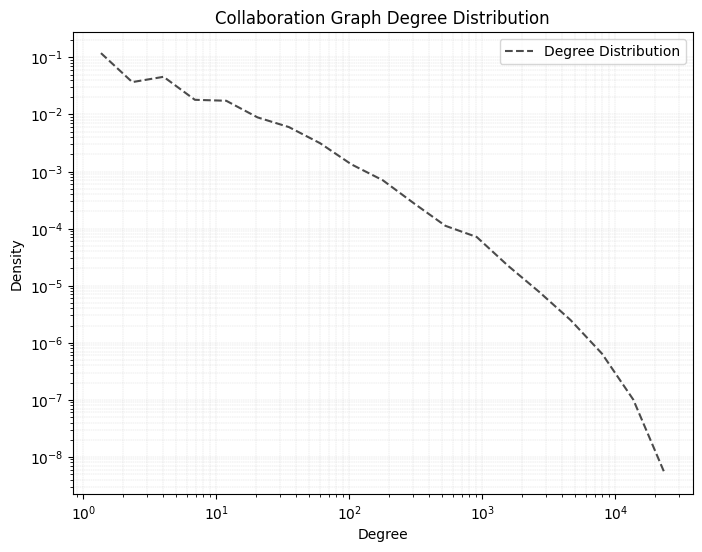

In [ ]:

def plot_degree_distribution(G, bins=20):
    """
    Computes and plots the log-binned degree distribution of a large graph.
    """
    # Extract degree sequence
    degrees = [d for _, d in G.degree()]
    
    if not degrees:
        print("No nodes in the graph!")
        return

    # Compute log-binned histogram
    log_bins = np.logspace(np.log10(1), np.log10(max(degrees)), bins)
    hist, bin_edges = np.histogram(degrees, bins=log_bins, density=True)

    # Compute bin centers for plotting
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    # Plot Degree Distribution
    plt.figure(figsize=(8, 6))
    plt.plot(bin_centers, hist, label="Degree Distribution", alpha=0.7, linestyle="dashed",color="black")

    # Log scales
    plt.xscale("log")
    plt.yscale("log")

    # Labels & Title
    plt.xlabel("Degree")
    plt.ylabel("Density")
    plt.legend()
    plt.title("Collaboration Graph Degree Distribution")

    # Improved Grid Visibility
    plt.grid(True, which="both", linestyle="--", linewidth=0.3, alpha=0.5)

    # Show plot
    plt.show()

# Example usage
plot_degree_distribution(G_users)


# **Scale-Free property testing**

Calculating best minimal value for power law fit
=== Scale-Free Analysis ===
Gamma: 2.3089
p-value: 0.0000
R: 11.9656
There is significant evidence to suggest the graph follows a power-law distribution


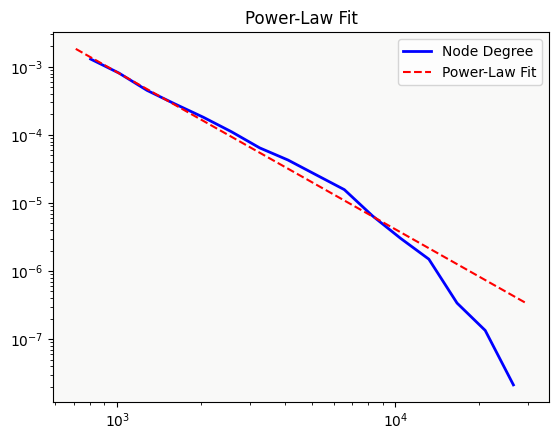

In [33]:

def test_scale_free(graph):

    # Get the degrees of nodes
    degrees = sorted([d for n, d in graph.degree()], reverse=True) 

    # Analyze the degree distribution using the powerlaw library
    fit = powerlaw.Fit(degrees, discrete=True)
    
    # Compare the power-law distribution with other distributions (e.g., exponential)
    R, p = fit.distribution_compare('power_law', 'exponential', normalized_ratio=True)
    
    # Print the results
    print("=== Scale-Free Analysis ===")
    print(f"Gamma: {fit.power_law.alpha:.4f}")
    print(f"p-value: {p:.4f}")
    print(f"R: {R:.4f}")
    
    if p > 0.05:
        print("There is insufficient evidence to conclude the graph follows a power-law distribution")
    else:
        print("There is significant evidence to suggest the graph follows a power-law distribution")
    
    # Visualize the degree distribution with the power-law fit
    fig = fit.plot_pdf(label="Node Degree", color='blue', linewidth=2)
    fit.power_law.plot_pdf(ax=fig, color='red', linestyle='--', label="Power-Law Fit")
    ax = plt.gca()  
    ax.set_facecolor('#f9f9f8') 
    plt.legend()
    plt.title("Power-Law Fit")
    plt.show()



test_scale_free(G_users)


Il grafo non è connesso, quindi per principio non può essere Small World per definizione. Furthermore, it shows low clustering coefficient further proving the hypothesis

# **Community Detection Analysis**

In this section, we detect communities within the projected organization graph using the Louvain algorithm, as it's one the most efficient for large graphs


In [3]:

def evaluate_community_metrics(graph, communities, algorithm_name=""):
    # Modularity Score
    print(algorithm_name, "algorithm:\n")
    modularity_score = modularity(graph, communities)
    print(f"Modularity Score : {modularity_score:.4f}")

    # Coverage
    coverage_score = coverage(graph, communities)
    print(f"Coverage Score : {coverage_score:.4f}")

    # Performance
    #performance_score = performance(graph, communities)
    #print(f"Performance Score : {performance_score:.4f}\n")
    

In [ ]:

louvain_comms = louvain_communities(G_users, weight='weight')


In [ ]:

evaluate_community_metrics(G_users, louvain_comms, algorithm_name="Louvain")


Louvain algorithm:

Modularity Score : 0.2811
Coverage Score : 0.4869
Girvan-Newman algorithm:

Modularity Score : 0.0311
Coverage Score : 0.9904


In [5]:

# Number of communities
num_communities = len(louvain_comms)
print(f"Number of communities: {num_communities}")

# Sizes of communities
community_sizes = [len(comm) for comm in louvain_comms]

# Check if there are more large or small communities
# Define a threshold for "large" and "small" (e.g., median size)
median_size = sorted(community_sizes)[len(community_sizes) // 2]

large_communities = sum(1 for size in community_sizes if size > median_size)
small_communities = num_communities - large_communities

print(f"Median community size: {median_size}")
print(f"Number of large communities: {large_communities}")
print(f"Number of small communities: {small_communities}")


Number of communities: 3382
Median community size: 2
Number of large communities: 1638
Number of small communities: 1744


In [40]:
### 1️⃣ **Create Nodes DataFrame**
# Ensure G_subgraph has 'num_projects' as a node attribute
nodes_data = [{'id': node, 'num_projects': G_users.nodes[node].get('num_projects', 0)} for node in G_users.nodes()]
nodes_df = pd.DataFrame(nodes_data)

### 2️⃣ **Create Edges DataFrame**
edges_data = [{'from': u, 'to': v, 'weight': G_users[u][v]['weight']} for u, v in G_users.edges()]
edges_df = pd.DataFrame(edges_data)

# Map each node to a community
community_map = {node: idx for idx, community in enumerate(louvain_comms) for node in community}

# Assign community ID to nodes_df
nodes_df['community_id'] = nodes_df['id'].map(community_map)
nodes_df['community_id'] = nodes_df['community_id'].astype(str)  # Convert to string for visualization

### 4️⃣ **Display Final DataFrames**
print("\n=== Nodes DataFrame (First 5 Rows) ===")
print(nodes_df.head())

print("\n=== Edges DataFrame (First 5 Rows) ===")
print(edges_df.head())



=== Nodes DataFrame (First 5 Rows) ===
           id  num_projects community_id
0      user_1             1           40
1    user_551             5           40
2   user_5999             1           40
3   user_1440           339          709
4  user_10798             3           54

=== Edges DataFrame (First 5 Rows) ===
     from          to  weight
0  user_1    user_551       1
1  user_1   user_5999       1
2  user_1   user_1440       1
3  user_1  user_10798       1
4  user_1  user_19080       1


## **Node Centrality Metrics Analysis**

In [50]:

# Efficient Degree Centrality (O(N))
degree_centrality = nx.degree_centrality(G_users)

# Approximate Betweenness Centrality using k-node sampling (e.g., k=500 for large graphs)
betweenness_centrality = nx.betweenness_centrality(G_users, weight='weight', k=30)

# Approximate Closeness Centrality by computing on a sampled subgraph
#sample_nodes = list(G_users.nodes())[:100]  # Take a subset of nodes
#closeness_centrality = nx.closeness_centrality(G_users.subgraph(sample_nodes), distance='weight', wf_improved=True)

# Create DataFrame with results
centrality_data = {
    'id': list(degree_centrality.keys()),
    'degree_centrality': list(degree_centrality.values()),
    'betweenness_centrality': [betweenness_centrality.get(n, 0) for n in degree_centrality.keys()],
    #'closeness_centrality': [closeness_centrality.get(n, 0) for n in degree_centrality.keys()]
}

centrality_df = pd.DataFrame(centrality_data).sort_values(by='degree_centrality', ascending=False)

centrality_df.head(10)


,id,degree_centrality,betweenness_centrality
138,user_17,0.272642,0.028591
123,user_299,0.189293,0.004054
132,user_607,0.179747,0.005841
203,user_645,0.178488,0.008774
140,user_8,0.177577,0.006048
156,user_76,0.175104,0.004147
133,user_58,0.166883,0.006056
134,user_512,0.165283,0.005567
136,user_502,0.155756,0.007870
144,user_84,0.152657,0.003658


We didn't measure Closeness centrality as the graph is disconnected so it would not be valid and won't lead to interesting new information

Degree Centrality: Misura la connettività locale. \
Betweenness Centrality: Indica il ruolo del nodo come intermediario nel grafo. \
Closeness Centrality: Valuta quanto rapidamente un nodo può raggiungere gli altri nodi. 

Come Usare Queste Metriche: \
Identificare nodi chiave (es. organizzazioni con alta influenza o connessioni strategiche)
Confrontare l'importanza relativa dei nodi

In [ ]:
nodes_df = nodes_df.merge(centrality_df,on='id',how='inner')


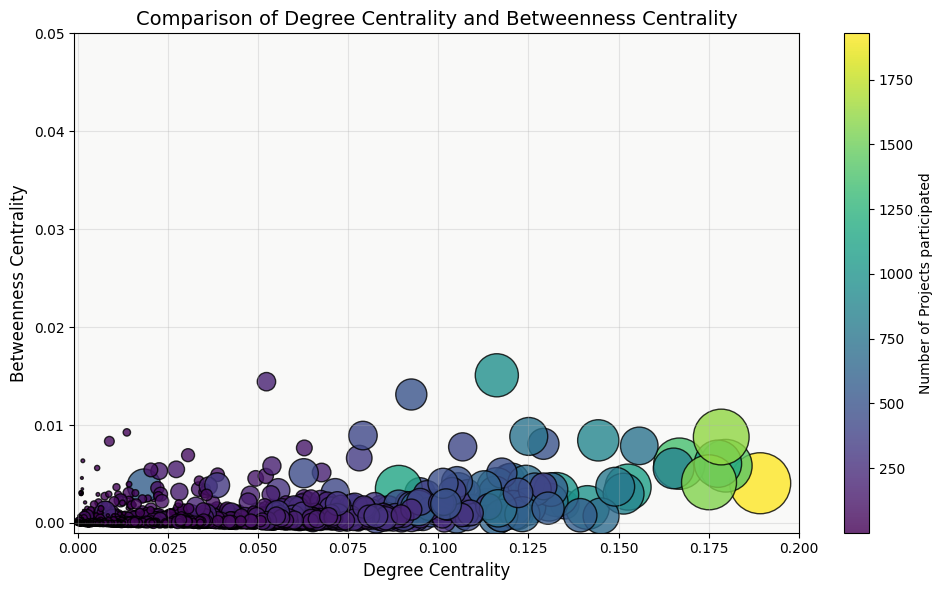

In [59]:

filtered_pepis_df = nodes_df[nodes_df['betweenness_centrality'] <= 0.02]

top_20_nodes = filtered_pepis_df.nlargest(250, 'degree_centrality')
plt.figure(figsize=(10, 6))
# Creating the scatter plot that confronts degree centrality and betweenness centrality. The shape and color scale with the number of collaborators in the organization
ax = plt.gca()  
ax.set_facecolor('#f9f9f8') 
scatter = plt.scatter(filtered_pepis_df['degree_centrality'], filtered_pepis_df['betweenness_centrality'], s=filtered_pepis_df['num_projects'],  
                      c=filtered_pepis_df['num_projects'], cmap='viridis', alpha=0.8, edgecolor='k'
)

# Titles and labels
plt.title("Comparison of Degree Centrality and Betweenness Centrality", fontsize=14)
plt.xlabel("Degree Centrality", fontsize=12)
plt.ylabel("Betweenness Centrality", fontsize=12)
plt.colorbar(scatter, label="Number of Projects participated")
plt.xlim(-0.001, 0.2)
plt.ylim(-0.001, 0.05)
plt.grid(alpha=0.3)
plt.tight_layout()

# Show the plot
plt.show()


## **Assortativity**


In this section, we measure degree assortativity


In [ ]:

def approximate_degree_assortativity(G, sample_fraction=0.1):
    """Compute approximate degree assortativity by sampling edges."""
    edges = list(G.edges())
    sample_size = int(len(edges) * sample_fraction)  # Sample fraction of edges
    sampled_edges = r.sample(edges, min(sample_size, len(edges)))

    # Create a subgraph from sampled edges
    G_sample = G.edge_subgraph(sampled_edges)

    return nx.degree_assortativity_coefficient(G_sample)

# Approximate Degree Assortativity with 10% edge sampling
assort_degree_approx = approximate_degree_assortativity(G_users, 0.1)
print("Degree Assortativity:", assort_degree_approx)



Degree Assortativity: -0.17031279673656277


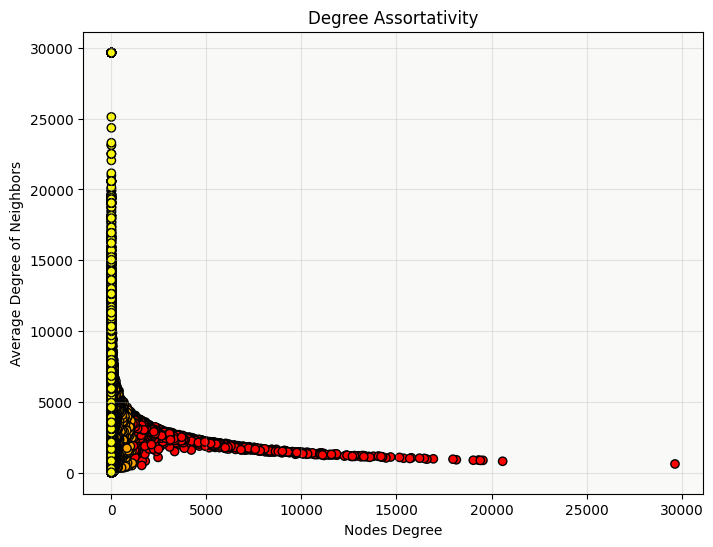

In [63]:
# Degrees and average neighbor degree
degrees = dict(G_users.degree())
knn = nx.average_neighbor_degree(G_users)

# Categorize nodes by degree (low, medium, high)
degree_values = np.array(list(degrees.values()))
low_threshold = np.percentile(degree_values, 66)
high_threshold = np.percentile(degree_values, 96)

node_colors = []
for degree in degrees.values():
    if degree <= low_threshold:
        node_colors.append('yellow')  # Low degree
    elif degree <= high_threshold:
        node_colors.append('orange')  # Medium degree
    else:
        node_colors.append('red')  # High degree

# Scatter plot with categorized colors
plt.figure(figsize=(8, 6))
ax = plt.gca()  
ax.set_facecolor('#f9f9f8') 
plt.scatter(
    list(degrees.values()), 
    list(knn.values()), 
    c=node_colors,  # Use node_colors for point colors
    alpha=1,
    edgecolor='black',  # Optional: Add black edges for better visibility
)
plt.xlabel("Nodes Degree")
plt.ylabel("Average Degree of Neighbors")
plt.title("Degree Assortativity")
plt.grid(alpha=0.3)
plt.show()


# **Research Question 2: How does the Collaboration Network evolve over time? Are collaborations typically recurrent or users tend to seek new collaborators?**

# **Creation of the Early, Middle and Late COllaboration Network**

In [64]:

# Step 1: Extract repository creation times from the bipartite graph and convert them to datetime format
repo_creation_times = {
    repo: pd.to_datetime(data["creation_time"]) 
    for repo, data in B.nodes(data=True) 
    if data.get("bipartite") == "repository"
}

# Step 2: Convert the dictionary into a DataFrame and sort by time
df_repos = pd.DataFrame(list(repo_creation_times.items()), columns=["Repo", "Time"])
df_repos.sort_values("Time", inplace=True)

# Step 3: Compute quantile-based thresholds (0.25, 0.50, 0.75)
quantile_dates = df_repos["Time"].quantile([0,0.35, 0.60, 0.85, 1])

# Step 4: Store the three key timestamps
first_date, early_date, middle_date, late_date, full_date = quantile_dates.values

print(first_date, early_date, middle_date, late_date, full_date)


2007-10-29T00:00:00.000000000 2008-12-15T00:00:00.000000000 2009-03-09T00:00:00.000000000 2009-05-18T00:00:00.000000000 2009-06-26T00:00:00.000000000


In [6]:
# Ensure all repository timestamps are converted to datetime format
for repo in repo_names:
    if repo in B and isinstance(B.nodes[repo].get("creation_time"), str):
        B.nodes[repo]["creation_time"] = pd.to_datetime(B.nodes[repo]["creation_time"])

In [9]:

# Function to filter repositories and clean users with degree zero
def filter_graph_by_date(pepis, cutoff_date):
    
    # Step 1: Remove repositories created after the cutoff date
    repos_to_remove = {repo for repo, data in B.nodes(data=True) 
                       if data.get("bipartite") == "repository" and data["creation_time"] > cutoff_date}
    
    print(len(repos_to_remove))

    pepis.remove_nodes_from(repos_to_remove)

    # Step 2: Remove user nodes with zero degree
    users_to_remove = {user for user in list(pepis.nodes()) 
                       if pepis.nodes[user].get("bipartite") == "user" and pepis.degree(user) == 0}
    
    pepis.remove_nodes_from(users_to_remove)
    
    return pepis


In [ ]:
import copy

# Example usage: Remove repositories created after date and clean isolated users
B_filtered_early = filter_graph_by_date(copy.deepcopy(B), early_date)
early_collaboration_graph = create_user_projection(B_filtered_early)
nx.write_gpickle(early_collaboration_graph, "user_user_projected_early.gpickle")

B_filtered_middle = filter_graph_by_date(copy.deepcopy(B), middle_date)
middle_collaboration_graph = create_user_projection(B_filtered_middle)
nx.write_gpickle(middle_collaboration_graph, "user_user_projected_middle.gpickle")

B_filtered_late = filter_graph_by_date(copy.deepcopy(B), late_date)
late_collaboration_graph = create_user_projection(B_filtered_late)
nx.write_gpickle(late_collaboration_graph, "user_user_projected_late.gpickle")


In [82]:
B_filtered_late = filter_graph_by_date(copy.deepcopy(B), late_date)
late_collaboration_graph = create_user_projection(B_filtered_late)
nx.write_gpickle(late_collaboration_graph, "user_user_projected_late.gpickle")

8324


In [83]:
total_repos = 56519

# Number of removed repositories in each period
removed_repos_early = 36724
removed_repos_middle = 22606
removed_repos_late = 8324

# Compute the number of remaining repositories
remaining_repos_early = total_repos - removed_repos_early
remaining_repos_middle = total_repos - removed_repos_middle
remaining_repos_late = total_repos - removed_repos_late

# Print results
print(f"Repositories in Early graph (2008-12-15): {remaining_repos_early}")
print(f"Repositories in Middle graph (2009-03-09): {remaining_repos_middle}")
print(f"Repositories in Late graph (2009-05-18): {remaining_repos_late}")


Repositories in Early graph (2008-12-15): 19795
Repositories in Middle graph (2009-03-09): 33913
Repositories in Late graph (2009-05-18): 48195


In [84]:
# Function to print graph statistics
def print_graph_stats(graph, name):
    num_nodes = graph.number_of_nodes()
    num_edges = graph.number_of_edges()
    print(f"{name}:")
    print(f"  Number of nodes: {num_nodes}")
    print(f"  Number of edges: {num_edges}")
    print("-" * 30)

# Print stats for each filtered bipartite graph
print_graph_stats(B_filtered_early, "early_collaboration_graph")
print_graph_stats(B_filtered_middle, "middle_collaboration_graph")
print_graph_stats(B_filtered_late, "late_collaboration graph")


early_collaboration_graph:
  Number of nodes: 82687
  Number of edges: 189303
------------------------------
middle_collaboration_graph:
  Number of nodes: 122511
  Number of edges: 294429
------------------------------
late_collaboration graph:
  Number of nodes: 158257
  Number of edges: 391991
------------------------------


In [6]:
# Load graphs from saved files
user_graphs = {
    "Early": nx.read_gpickle("user_user_projected_early.gpickle"),
    "Middle": nx.read_gpickle("user_user_projected_middle.gpickle"),
    "Late": nx.read_gpickle("user_user_projected_late.gpickle"),
    "Full": nx.read_gpickle("user_user_projected.gpickle")
}


In [65]:
# Step 6: Print number of nodes and edges for each user-user graph
for interval, graph in user_graphs.items():
    print(f"{interval} Graph:")
    print(f"  Number of nodes: {graph.number_of_nodes()}")
    print(f"  Number of edges: {graph.number_of_edges()}")
    print("-" * 30)

Early Graph:
  Number of nodes: 58346
  Number of edges: 6434649
------------------------------
Middle Graph:
  Number of nodes: 81123
  Number of edges: 8753082
------------------------------
Late Graph:
  Number of nodes: 99623
  Number of edges: 10468553
------------------------------
Full Graph:
  Number of nodes: 108748
  Number of edges: 11058194
------------------------------


## **Temporal Analyses**

In [ ]:

# Function to estimate clustering coefficient with sampling
def estimate_clustering_coefficient(graph, sample_size=10000):
    if graph.number_of_nodes() > sample_size:
        sample_nodes = r.sample(list(graph.nodes()), sample_size)
    else:
        sample_nodes = graph.nodes()
    
    clustering_values = nx.clustering(graph, nodes=sample_nodes, weight="weight")
    return sum(clustering_values.values()) / len(clustering_values)  # Average

# Print results
print(f"Estimated Clustering Coefficient:")

early_clustering = estimate_clustering_coefficient(early_collaboration_graph, sample_size=10000)
print(f"  Early: {early_clustering:.4f}")

middle_clustering = estimate_clustering_coefficient(middle_collaboration_graph, sample_size=10000)
print(f"  Middle: {middle_clustering:.4f}")

late_clustering = estimate_clustering_coefficient(late_collaboration_graph, sample_size=10000)
print(f"  Late: {late_clustering:.4f}")



In [ ]:

# Function to estimate clustering coefficient with sampling
def estimate_clustering_coefficient(graph, sample_size=1000):
    """
    Estimates the average clustering coefficient of a graph using sampling.
    """
    if graph.number_of_nodes() > sample_size:
        sample_nodes = r.sample(list(graph.nodes()), sample_size)
    else:
        sample_nodes = graph.nodes()
    
    clustering_values = nx.clustering(graph, nodes=sample_nodes, weight="weight")
    return sum(clustering_values.values()) / len(clustering_values)  # Average

# Compute and print estimated clustering coefficient for each graph
print("Estimated Clustering Coefficient:")
for phase, graph in user_graphs.items():
    clustering = estimate_clustering_coefficient(graph, sample_size=5)
    print(f"  {phase}: {clustering:.4f}")


Estimated Clustering Coefficient:
  Early: 0.0039
  Middle: 0.0030
  Late: 0.0025
  Full: 0.0020


In [ ]:
pepis_clustering = estimate_clustering_coefficient(G_users, sample_size=10000)
print(f"  full: {pepis_clustering:.4f}")

  full: 0.0023


I clustering coefficient erano piu alti all'inizio, il che può essere prevedibile, dato che con il corso del tempo il numero di archi è aumentato esponenzialmente rispetto al numero dei nodi.

very low clustering coefficients are common in large, sparse networks, especially in user-user projected bipartite graphs like yours. Here’s why:

Projected Graphs Reduce Clustering

Your original bipartite graph (users-repositories) does not naturally have triangles.
When projecting to the user-user graph, many nodes become high-degree hubs connected through shared repositories rather than forming local triangles.
Scale-Free and Sparse Networks

Your edge density is very low compared to possible connections.
The number of edges grows almost linearly with nodes, suggesting low local density, typical of scale-free networks.

In [ ]:

# Extract number of nodes and edges from each graph
num_nodes = [G.number_of_nodes() for G in user_graphs.values()]
num_edges = [G.number_of_edges() for G in user_graphs.values()]
intervals = list(user_graphs.keys())

# Compute density for each interval
densities = []
for N, E in zip(num_nodes, num_edges):
    max_edges = (N * (N - 1)) / 2  # Maximum possible edges in an undirected graph
    density = E / max_edges if max_edges > 0 else 0  # Avoid division by zero
    densities.append(density)

# Create a DataFrame to display results
df_density = pd.DataFrame({
    "Interval": intervals,
    "Nodes": num_nodes,
    "Edges": num_edges,
    "Density": densities
})

df_density

,Interval,Nodes,Edges,Density
0,Early,58346,6434649,0.00378
1,Middle,81123,8753082,0.00266
2,Late,99623,10468553,0.00211
3,Full,108748,11058194,0.00187


Infact we can see that the density almost dropped by half from the early stages of the graph.

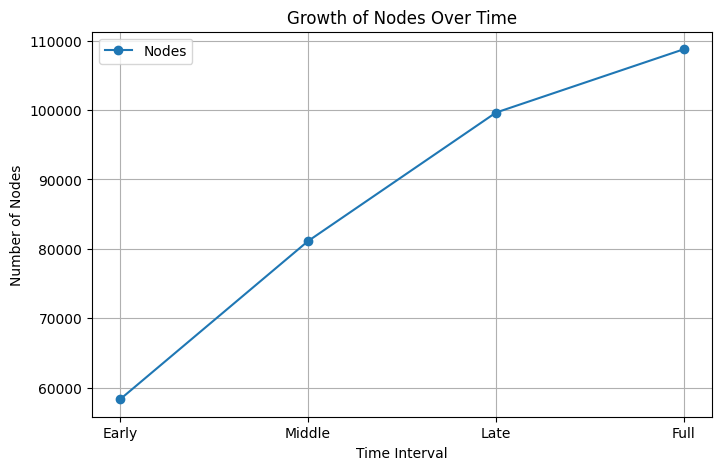

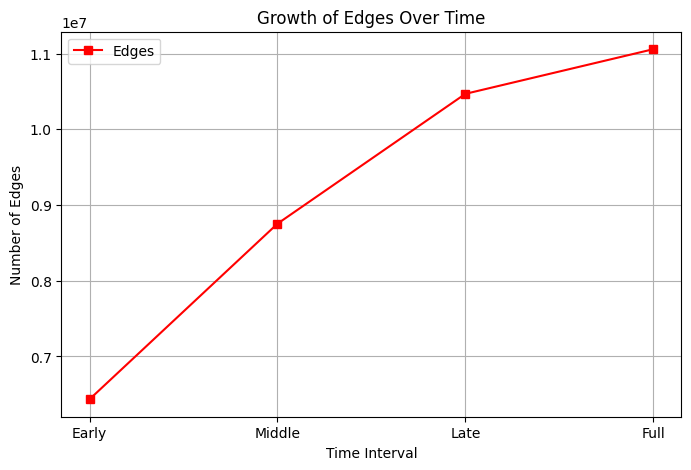

In [68]:

# Plot Nodes Growth
plt.figure(figsize=(8, 5))
plt.plot(intervals, num_nodes, marker='o', linestyle='-', label="Nodes")
plt.xlabel("Time Interval")
plt.ylabel("Number of Nodes")
plt.title("Growth of Nodes Over Time")
plt.grid(True)
plt.legend()
plt.show()

# Plot Edges Growth
plt.figure(figsize=(8, 5))
plt.plot(intervals, num_edges, marker='s', linestyle='-', color='r', label="Edges")
plt.xlabel("Time Interval")
plt.ylabel("Number of Edges")
plt.title("Growth of Edges Over Time")
plt.grid(True)
plt.legend()
plt.show()


We can see a linear growth in the number of nodes and edges over time, only slowing down in the last 3 months period.

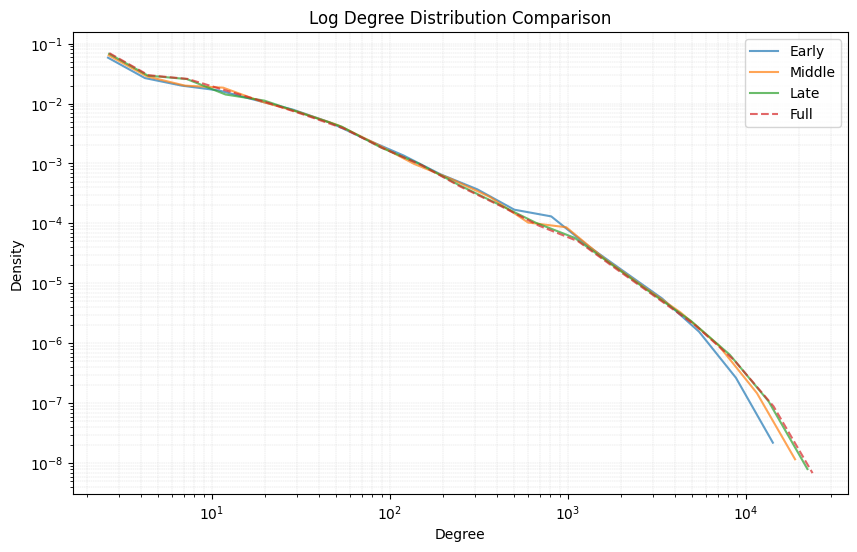

In [69]:

# Function to compute log-binned degree distribution
def compute_log_binned_degree_distribution(graph, bins=20):
    degrees = [d for _, d in graph.degree()]
    
    if not degrees:
        return [], []

    # Use log bins for better visualization
    log_bins = np.logspace(np.log10(min(degrees) + 1), np.log10(max(degrees) + 1), bins)
    
    # Compute histogram with log bins
    hist, bin_edges = np.histogram(degrees, bins=log_bins, density=True)
    
    # Compute bin centers for plotting
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    
    return bin_centers, hist

# Assuming the user has four NetworkX graphs: early_collaboration_graph, middle_collaboration_graph, late_collaboration_graph, full_collaboration_graph

# Compute log-binned degree distributions
early_x, early_y = compute_log_binned_degree_distribution(early_collaboration_graph)
middle_x, middle_y = compute_log_binned_degree_distribution(middle_collaboration_graph)
late_x, late_y = compute_log_binned_degree_distribution(late_collaboration_graph)
full_x, full_y = compute_log_binned_degree_distribution(G_users)

# Plot the log-binned degree distributions
plt.figure(figsize=(10, 6))
plt.plot(early_x, early_y, label="Early", alpha=0.7)
plt.plot(middle_x, middle_y, label="Middle", alpha=0.7)
plt.plot(late_x, late_y, label="Late", alpha=0.7)
plt.plot(full_x, full_y, label="Full", alpha=0.7, linestyle="dashed")

plt.xscale("log")
plt.yscale("log")
plt.xlabel("Degree")
plt.ylabel("Density")
plt.legend()
plt.title("Log Degree Distribution Comparison")
plt.grid(True, which="both", linestyle="--", linewidth=0.3, alpha=0.5)
plt.show()


Now, Community Detection and comparison of each interval with the final graph:

In [ ]:

# Run Louvain community detection for each graph
partitions = {}
modularities = {}

for name, G in user_graphs.items():
    partition = louvain_communities(G, weight='weight')
    modularity_score = modularity(G, partition)

    partitions[name] = partition
    modularities[name] = modularity_score


In [ ]:

# Create DataFrame to compare results
df_community = pd.DataFrame({
    "Interval": ["Early", "Middle", "Late", "Full"],
    "Modularity": [modularities["Early"], modularities["Middle"], modularities["Late"], modularities["Full"]],
})

df_community

,Interval,Modularity,ARI with Full
0,Early,0.336062,0.331001
1,Middle,0.298589,0.335159
2,Late,0.284773,0.338500
3,Full,0.280181,NaN


## **Collaboration Recurrency Analysis**

In [ ]:

def filter_graph_by_date_range(pepis, start_date, end_date):
    """
    Filters the bipartite graph to retain only repositories created between start_date and end_date,
    and removes users who have no contributions left after filtering.
    """

    # Step 1: Remove repositories created outside the given range
    repos_to_remove = {repo for repo, data in pepis.nodes(data=True) 
                       if data.get("bipartite") == "repository" and 
                       (data["creation_time"] < start_date or data["creation_time"] > end_date)}

    pepis.remove_nodes_from(repos_to_remove)

    # Step 2: Remove user nodes with zero degree after filtering repositories
    users_to_remove = {user for user in list(pepis.nodes()) 
                       if pepis.nodes[user].get("bipartite") == "user" and pepis.degree(user) == 0}

    pepis.remove_nodes_from(users_to_remove)

    return pepis


def compute_edge_retention(early_graph, early_middle_graph):
    """
    Computes the percentage of edges in `early_middle_graph` that are not present in `early_graph`.
    """
    # Convert edge lists to sets for fast set operations
    early_edges = set(early_graph.edges())
    early_middle_edges = set(early_middle_graph.edges())

    # Compute the difference (new edges in Early-Middle that were not in Early)
    new_edges = early_middle_edges - early_edges

    # Compute the retention percentage
    retention_percentage = len(new_edges) / len(early_middle_edges) if early_middle_edges else 0

    return retention_percentage * 100  # Convert to percentage


In [ ]:
B_interval_early_middle = filter_graph_by_date_range(copy.deepcopy(B), early_date, middle_date)
early_middle_collaboration_graph = create_user_projection(B_interval_early_middle)
collaboration_recurrency_early_middle = compute_edge_retention(early_collaboration_graph, early_middle_collaboration_graph)

print(f"Percentage of new collaborations in Early-Middle interval compared to the previous stage: {collaboration_recurrency_early_middle:.2f}% \n")

B_interval_middle_late = filter_graph_by_date_range(copy.deepcopy(B), middle_date, late_date)
middle_late_collaboration_graph = create_user_projection(B_interval_middle_late)
collaboration_recurrency_middle_late = compute_edge_retention(middle_collaboration_graph, middle_late_collaboration_graph)

print(f"Percentage of new collaborations in Middle-Late interval compared to the previous stage: {collaboration_recurrency_middle_late:.2f}% \n")

B_interval_late_full = filter_graph_by_date_range(copy.deepcopy(B), late_date, full_date)
late_full_collaboration_graph = create_user_projection(B_interval_late_full)
collaboration_recurrency_late_full = compute_edge_retention(late_collaboration_graph, late_full_collaboration_graph)

print(f"Percentage of new collaborations in Late-Full interval compared to the previous stage: {collaboration_recurrency_late_full:.2f}% \n")

Percentage of new collaborations in Early-Middle interval compared to the previous stage: 81.66% 

Percentage of new collaborations in Middle-Late interval compared to the previous stage: 75.74% 

Percentage of new collaborations in Late-Full interval compared to the previous stage: 71.31% 

